## **[:+:] -- Registration & Alignment for Neuroimagery -- [:+:]** 

In [13]:
from pystackreg import StackReg
from skimage import data, io
from skimage import registration
from skimage.transform import warp
# from skimage import register_translation
# from skimage.feature.register_translation import _upsampled_dft
# from scipy.ndimage import fourier_shift
# import scipy.io 
# import imageio 
# import sys
# import matplotlib.animation as animation
from matplotlib import pyplot as plt
import glob
import tifffile as tif
import numpy as np
from scipy.io import loadmat
import mat73
from scipy.ndimage import shift
import os 
import image_registration as imreg
import seaborn as sb
import pandas as pd
# print(sys.path)
# import cv2
# import sys
# print(sys.path)


normPath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized")
refMat56_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNS.mat")
refMat68_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse68_MKgamma.mat")
refMat97_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse97_MKNS.mat")
deformMat56_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_deform\Afterregis_181300_deform_ref56.mat")
deformMat68_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_deform\Afterregis_181300_deform_ref68.mat")
deformMat97_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_deform\Afterregis_181300_deform_ref97.mat")
deformTiff56_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\Afterregis_181300_deform_ref56x180_300.tiff")
deformTiff68_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\Afterregis_181300_deform_ref68x180_300.tiff")
deformTiff97_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\Afterregis_181300_deform_ref97x180_300.tiff")
refMouse56_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNSx180_300.tiff")
refMouse68_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse68_MKgammax180_300.tiff")
refMouse97_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse97_MKNSx180_300.tiff")
unalignedFile180_300_refPrefix= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks\unaligned180_300_refPrefix.tiff")
unalignedFile180_300_noPrefix= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks\unaligned180_300_noPrefix.tiff")
unalignedFile68_prefix= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks\unaligned_ref68_prefix.tiff")
unalignedFile97_prefix= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks\unaligned_ref97_prefix.tiff")
matPath = (r'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_files') 
samplePath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample")
tiffPath = (r'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_files') 
tiffFile= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_sample\Norm_Mouse56_SNS.tiff")
subStackPath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_subStacks")
subStackPath1= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_subStacks\p1")
superStackPath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_superStacks")
registeredPath= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered")
diceMatrix_csvPath= (r'C:\Users\richa\OneDrive\Neuroscience\Code\Repo\diceMatrix.csv')


psr_avg56_RB_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m56_RB.tiff")
psr_avg68_RB_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m68_RB.tiff")
psr_avg97_RB_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m97_RB.tiff")
psr_avg56_AF_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m56_AF.tiff")
psr_avg68_AF_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m68_AF.tiff")
psr_avg97_AF_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m97_AF.tiff")
psr_avg56_SR_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m56_SR.tiff")
psr_avg68_SR_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m68_SR.tiff")
psr_avg97_SR_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m97_SR.tiff")
psr_avg56_BL_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m56_BL.tiff")
psr_avg68_BL_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m68_BL.tiff")
psr_avg97_BL_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\psr_avg_m97_BL.tiff")
dft_avg56_File= (r"C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\TIFF_registered\dft_avgTensor.tiff")

diceFrame= pd.read_csv(diceMatrix_csvPath)
unaligned180_300= io.imread(unalignedFile180_300_refPrefix)[:, :, 120:]
std_Unaligned= np.std(unaligned180_300, axis= 2)
vLen= unaligned180_300.shape[2]

refMean56 = np.mean(io.imread(refMouse56_File), axis=2)
refMean68 = np.mean(io.imread(refMouse68_File), axis=2)
refMean97 = np.mean(io.imread(refMouse97_File), axis=2)
psr_avg56_RB= io.imread(psr_avg56_RB_File)
psr_avg56_AF= io.imread(psr_avg56_AF_File)
psr_avg56_SR= io.imread(psr_avg56_SR_File)
psr_avg56_BL= io.imread(psr_avg56_BL_File)
psr_avg68_RB= io.imread(psr_avg68_RB_File)
psr_avg68_AF= io.imread(psr_avg68_AF_File)
psr_avg68_SR= io.imread(psr_avg68_SR_File)
psr_avg68_BL= io.imread(psr_avg68_BL_File)
psr_avg97_RB= io.imread(psr_avg97_RB_File)
psr_avg97_AF= io.imread(psr_avg97_AF_File)
psr_avg97_SR= io.imread(psr_avg97_SR_File)
psr_avg97_BL= io.imread(psr_avg97_BL_File)
deform_avg56= io.imread(deformTiff56_File)
deform_avg68= np.transpose(io.imread(deformTiff68_File), (1,2,0))
deform_avg97= np.transpose(io.imread(deformTiff97_File), (1,2,0))
opFlow_ilk_avg56 = io.imread(registeredPath + "\opFlow_ilk_ref56.tiff")[ :, :, 1:9841]
opFlow_ilk_avg68 = io.imread(registeredPath + "\opFlow_ilk_ref68.tiff")[ :, :, 1:9841]
opFlow_ilk_avg97 = io.imread(registeredPath + "\opFlow_ilk_ref97.tiff")[ :, :, 1:9841]
opFlow_tvl1_avg56 = io.imread(registeredPath + "\opFlow_tvl1_ref56.tiff")
opFlow_tvl1_avg68 = io.imread(registeredPath + "\opFlow_tvl1_ref68.tiff")
opFlow_tvl1_avg97 = io.imread(registeredPath + "\opFlow_tvl1_ref97.tiff")

std_psr_avg56_RB= np.std(psr_avg56_RB, axis= 2)
std_psr_avg56_AF= np.std(psr_avg56_AF, axis= 2)
std_psr_avg56_SR= np.std(psr_avg56_SR, axis= 2)
std_psr_avg56_BL= np.std(psr_avg56_BL, axis= 2)
std_psr_avg68= np.std(psr_avg68_RB, axis= 2)
std_psr_avg68_AF= np.std(psr_avg68_AF, axis= 2)
std_psr_avg68_SR= np.std(psr_avg68_SR, axis= 2)
std_psr_avg68_BL= np.std(psr_avg68_BL, axis= 2)
std_psr_avg97= np.std(psr_avg97_RB, axis= 2)
std_psr_avg97_AF= np.std(psr_avg97_AF, axis= 2)
std_psr_avg97_SR= np.std(psr_avg97_SR, axis= 2)
std_psr_avg97_BL= np.std(psr_avg97_BL, axis= 2)
std_deform_avg56= np.std(deform_avg56, axis=2)
std_deform_avg68= np.std(deform_avg68, axis=2)
std_deform_avg97= np.std(deform_avg97, axis=2)
std_opFlow_ilk_avg56= np.std(opFlow_ilk_avg56, axis=2)
std_opFlow_ilk_avg68= np.std(opFlow_ilk_avg68, axis=2)
std_opFlow_ilk_avg97= np.std(opFlow_ilk_avg97, axis=2)
std_opFlow_tvl1_avg56= np.std(opFlow_tvl1_avg56, axis=2)
std_opFlow_tvl1_avg68= np.std(opFlow_tvl1_avg68, axis=2)
std_opFlow_tvl1_avg97= np.std(opFlow_tvl1_avg97, axis=2)
max_psr_avg56_RB= np.amax(psr_avg56_RB, axis= 2)
max_psr_avg56_AF= np.amax(psr_avg56_AF, axis= 2)
max_psr_avg56_SR= np.amax(psr_avg56_SR, axis= 2)
max_psr_avg56_BL= np.amax(psr_avg56_BL, axis= 2)
max_psr_avg68= np.amax(psr_avg68_RB, axis= 2)
max_psr_avg68_AF= np.amax(psr_avg68_AF, axis= 2)
max_psr_avg68_SR= np.amax(psr_avg68_SR, axis= 2)
max_psr_avg68_BL= np.amax(psr_avg68_BL, axis= 2)
max_psr_avg97= np.amax(psr_avg97_RB, axis= 2)
max_psr_avg97_AF= np.amax(psr_avg97_AF, axis= 2)
max_psr_avg97_SR= np.amax(psr_avg97_SR, axis= 2)
max_psr_avg97_BL= np.amax(psr_avg97_BL, axis= 2)
max_deform56= np.amax(deform_avg56, axis= 2)
max_deform68= np.amax(deform_avg68, axis= 2)
max_deform97= np.amax(deform_avg97, axis= 2)
max_opFlow_ilk_avg56= np.amax(opFlow_ilk_avg56, axis=2)
max_opFlow_ilk_avg68= np.amax(opFlow_ilk_avg68, axis=2)
max_opFlow_ilk_avg97= np.amax(opFlow_ilk_avg97, axis=2)
max_opFlow_tvl1_avg56= np.amax(opFlow_tvl1_avg56, axis=2)
max_opFlow_tvl1_avg68= np.amax(opFlow_tvl1_avg68, axis=2)
max_opFlow_tvl1_avg97= np.amax(opFlow_tvl1_avg97, axis=2)
mean_psr_avg56_RB= np.mean(psr_avg56_RB, axis= 2)
mean_psr_avg56_AF= np.mean(psr_avg56_AF, axis= 2)
mean_psr_avg56_SR= np.mean(psr_avg56_SR, axis= 2)
mean_psr_avg56_BL= np.mean(psr_avg56_BL, axis= 2)
mean_psr_avg68= np.mean(psr_avg68_RB, axis= 2)
mean_psr_avg68_AF= np.mean(psr_avg68_AF, axis= 2)
mean_psr_avg68_SR= np.mean(psr_avg68_SR, axis= 2)
mean_psr_avg68_BL= np.mean(psr_avg68_BL, axis= 2)
mean_psr_avg97= np.mean(psr_avg97_RB, axis= 2)
mean_psr_avg97_AF= np.mean(psr_avg97_AF, axis= 2)
mean_psr_avg97_SR= np.mean(psr_avg97_SR, axis= 2)
mean_psr_avg97_BL= np.mean(psr_avg97_BL, axis= 2)
mean_deform56= np.mean(deform_avg56, axis= 2)
mean_deform68= np.mean(deform_avg68, axis= 2)
mean_deform97= np.mean(deform_avg97, axis= 2)
mean_opFlow_ilk_avg56= np.mean(opFlow_ilk_avg56, axis=2)
mean_opFlow_ilk_avg68= np.mean(opFlow_ilk_avg68, axis=2)
mean_opFlow_ilk_avg97= np.mean(opFlow_ilk_avg97, axis=2)
mean_opFlow_tvl1_avg56= np.mean(opFlow_tvl1_avg56, axis=2)
mean_opFlow_tvl1_avg68= np.mean(opFlow_tvl1_avg68, axis=2)
mean_opFlow_tvl1_avg97= np.mean(opFlow_tvl1_avg97, axis=2)
dft_reg= io.imread(dft_avg56_File)
std_dft_reg= np.std(dft_reg, axis=2 )



## __[+]__ Functions

In [94]:
sb.set_theme(style="dark", palette=None)
plt.style.use("dark_background")

def displayHeatmap(imgMatrix, sizer= 0.6, title= "Heatmap"):
    print("// -- Shape: " + str(imgMatrix.shape)+ "-- [::]")
    plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
    plt.title(title)
    sb.heatmap(data= imgMatrix.T, xticklabels=False, yticklabels=False )
    plt.show()
    

def tensorize(filename, beginDex=0):
    print(filename)
    if os.path.isfile(filename):
        baseName = os.path.basename(filename)
        if baseName.endswith('.mat'): 
            print("\n[::] --- Fields of the MAT file: --- " + str(filename))
            filename= loadmat(filename)
            vTensor = filename['MouseData']
            print(filename.keys())
            print("Header: " + str(filename['__header__']))
            print("Version: " + str(filename['__version__']))
            print("Globals: " + str(filename['__globals__']))
            print("[::] --- Type and dimensions of MAT img data: ")
            print(type(vTensor))
            print((vTensor.shape))
            print("Elements of type: " + str(type(vTensor[0][0][0])))
            print((vTensor[0][0][0+beginDex]))
            print((vTensor[1][1][1+beginDex]))
            print((vTensor[2][2][2+beginDex]))
        elif baseName.endswith('.tiff'):
            print("\n[::] --- Type and dimensions of TIFF File: --- " + str(filename))
            filename= io.imread(filename)
            print(type(filename))
            shape= filename.shape
            print("Shape: " + str(shape))
            if len(shape)==3 :
                print("Elements of type: " + str(type(filename[0][0][0])))
                print((filename[0][0][0]))
                print((filename[1][1][1]))
                print((filename[2][2][2]))
            else: 
                print("Elements of type: " + str(type(filename[0][0])))
                print((filename[0][0]))
                print((filename[1][1]))
                print((filename[2][2]))
        else: print("\nInvalid File type, no tensorInfo")
    elif isinstance(filename, np.ndarray):
        print("\n[::] --- Type and dimensions of Tensor: --- " )
        shape= filename.shape
        print("Shape: " + str(shape))
        if len(shape)==3 :
            print("Elements of type: " + str(type(filename[0][0][0])))
            print((filename[0][0][0]))
            print((filename[1][1][1]))
            print((filename[2][2][2]))
        else: 
            print("Elements of type: " + str(type(filename[0][0])))
            print((filename[0][0]))
            print((filename[1][1]))
            print((filename[2][2]))
    else: print("\nNo tensorInfo, Invalid Input")


def mattotiff(matFile, outPath, beginDex=0, enDex=3600, showTensorInfo=False, addendum=""):
    matData= loadmat(matFile)
    vTensor = matData['MouseData']
    vTensor= vTensor[:, :, beginDex:enDex]

    # [+]- Save 3d tensor as a tiff image stack, saves into current directory by default
    matBaseName = os.path.basename(matFile)
    tiffName = os.path.splitext(matBaseName)[0] + addendum+".tiff"
    output_filename = os.path.join(outPath, tiffName)
    tif.imsave(output_filename, vTensor, bigtiff=True)

    #[+]- Access the new  TIFF file, and makes sure its dimensions are proper
    if showTensorInfo:
        print("matFile: " + matFile)
        print("matBaseName: " + matBaseName)
        print("tiffName: " + tiffName)
        print("output_filename: " + output_filename)
        tensorize(matFile, beginDex)
    return output_filename

def mat73totiff(matFile, outPath, beginDex=0, enDex=3600, showTensorInfo=False, addendum=""):
    matData= mat73.loadmat(matFile)
    vTensor= np.asarray(matData['Afterregis'])
    rotTensor= np.empty((vTensor.shape[1],vTensor.shape[2],vTensor.shape[0]))
    for i in range(vTensor.shape[0]):
        slice = vTensor[i, :, :, ]
        slice= np.reshape(slice, (slice.shape[0], slice.shape[1], 1) )
        rotTensor= np.concatenate((rotTensor,slice ), axis=2)
    matBaseName = os.path.basename(matFile)
    tiffName = os.path.splitext(matBaseName)[0] + addendum+".tiff"
    output_filename = os.path.join(outPath, tiffName)
    tif.imsave(output_filename, vTensor, bigtiff=True)
    if showTensorInfo:
        print("matFile: " + matFile)
        print("matBaseName: " + matBaseName)
        print("tiffName: " + tiffName)
        print("output_filename: " + output_filename)
    return output_filename

def euclidistance(a, b):
    # Make sure a and b have the same shape
    assert a.shape == b.shape
    # Calculate the difference between the two arrays element-wise
    diff = a - b
    # [+] Euclidean distance = frobenius norm of the sum of squared differences
    distance = np.linalg.norm(diff)
    return distance

def slice_n_Dice(mat1, mat2):
    assert mat2.shape == mat1.shape
    intersection = np.sum(mat1 * mat2)
    union = np.sum(mat1) + np.sum(mat2)
    dice = (2 * intersection) / union
    return dice

#[::]-- Euclidian distance has been deprecated, only using dice now
def distanceMatrix(vTensor, fMatrix,  endex, begindex=0):
    # eDists= np.empty(0)
    diceSims= np.empty(0)
    for i in range(begindex, endex):
        # eDist= euclidistance((vTensor[:, :, i]), fMatrix)
        # eDists= np.append(eDists, eDist)
        diceSim= slice_n_Dice((vTensor[:, :, i]), fMatrix)
        diceSims= np.append(diceSims, diceSim)
    # return eDists, diceSims
    return diceSims

def DFTreg(vTensor, fMatrix,  endex, begindex=0):
    dft_avgTensor =np.reshape(fMatrix, (fMatrix.shape[0], fMatrix.shape[1], 1))
    offsets= np.empty(0)
    for i in range(begindex, endex):
        imReg= imreg.register_images(fMatrix, (vTensor[:, :, i]), return_registered=True )
        alignedMat= np.reshape(imReg[2], (imReg[2].shape[0], imReg[2].shape[1], 1))
        dft_avgTensor= np.concatenate((dft_avgTensor, alignedMat), axis=2)
        offDist= np.sqrt( imReg[0]**2 + imReg[1]**2)
        offsets= np.append(offsets, offDist )
    return dft_avgTensor, offsets

def opticalFlowReg_tvl1(vTensor, refMat,  endex, begindex=0):
    # opFlow_Tensor =np.reshape(refMat, (refMat.shape[0], refMat.shape[1], 1))
    opFlow_Tensor= np.empty((refMat.shape[0], refMat.shape[1], 0))
    nr, nc = refMat.shape
    for i in range(begindex, endex):
        frame= vTensor[:, :, i]
        v, u = registration.optical_flow_tvl1(refMat, frame)
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
        frame_warp = warp(frame, np.array([row_coords + v, col_coords + u]), mode='edge')
        frame_warp =np.reshape(frame_warp, (frame_warp.shape[0], frame_warp.shape[1], 1))
        opFlow_Tensor= np.concatenate((opFlow_Tensor, frame_warp), axis=2)
    return opFlow_Tensor

def opticalFlowReg_ilk(vTensor, refMat,  endex, begindex=0):
    # opFlow_Tensor =np.reshape(refMat, (refMat.shape[0], refMat.shape[1], 1))
    opFlow_Tensor= np.empty((refMat.shape[0], refMat.shape[1], 0))
    nr, nc = refMat.shape
    for i in range(begindex, endex):
        frame= vTensor[:, :, i]
        v, u = registration.optical_flow_ilk(refMat, frame)
        row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
        frame_warp = warp(frame, np.array([row_coords + v, col_coords + u]), mode='edge')
        frame_warp =np.reshape(frame_warp, (frame_warp.shape[0], frame_warp.shape[1], 1))
        opFlow_Tensor= np.concatenate((opFlow_Tensor, frame_warp), axis=2)
    return opFlow_Tensor

## __[+]__ Distance Matrix

In [16]:
#[:]-- Create the distance matrices
unaligned_DM= (distanceMatrix(unaligned180_300, refMean56, endex=vLen, begindex= 0))
psr_ref56_RB_DM= (distanceMatrix(psr_avg56_RB, refMean56, endex=vLen, begindex= 0))
psr_ref56_AF_DM= (distanceMatrix(psr_avg56_AF, refMean56, endex=vLen, begindex= 0))
psr_ref56_SR_DM= (distanceMatrix(psr_avg56_SR, refMean56, endex=vLen, begindex= 0))
psr_ref56_BL_DM= (distanceMatrix(psr_avg56_BL, refMean56, endex=vLen, begindex= 0))
deform56_DM= distanceMatrix(deform_avg56, refMean56, endex= vLen, begindex= 0)
opFlow_ilk_ref56_DM= (distanceMatrix(opFlow_ilk_avg56, refMean56, endex=vLen, begindex= 0))
opFlow_tvl1_ref56_DM= (distanceMatrix(opFlow_tvl1_avg56, refMean56, endex=vLen, begindex= 0))
psr_ref68_RB_DM= (distanceMatrix(psr_avg68_RB, refMean68, endex=vLen, begindex= 0))
psr_ref68_AF_DM= (distanceMatrix(psr_avg68_AF, refMean68, endex=vLen, begindex= 0))
psr_ref68_SR_DM= (distanceMatrix(psr_avg68_SR, refMean68, endex=vLen, begindex= 0))
psr_ref68_BL_DM= (distanceMatrix(psr_avg68_BL, refMean68, endex=vLen, begindex= 0))
deform68_DM= distanceMatrix(deform_avg68, refMean68, endex= vLen, begindex= 0)
opFlow_ilk_ref68_DM= (distanceMatrix(opFlow_ilk_avg68, refMean68, endex=vLen, begindex= 0))
opFlow_tvl1_ref68_DM= (distanceMatrix(opFlow_tvl1_avg68, refMean68, endex=vLen, begindex= 0))
psr_ref97_RB_DM= (distanceMatrix(psr_avg97_RB, refMean97, endex=vLen, begindex= 0))
psr_ref97_AF_DM= (distanceMatrix(psr_avg97_AF, refMean97, endex=vLen, begindex= 0))
psr_ref97_SR_DM= (distanceMatrix(psr_avg97_SR, refMean97, endex=vLen, begindex= 0))
psr_ref97_BL_DM= (distanceMatrix(psr_avg97_BL, refMean97, endex=vLen, begindex= 0))
deform97_DM= distanceMatrix(deform_avg97, refMean97, endex= vLen, begindex= 0)
opFlow_ilk_ref97_DM= (distanceMatrix(opFlow_ilk_avg97, refMean97, endex=vLen, begindex= 0))
opFlow_tvl1_ref97_DM= (distanceMatrix(opFlow_tvl1_avg97, refMean97, endex=vLen, begindex= 0))
dft_ref56_DM= (distanceMatrix(dft_reg, refMean56, endex=vLen, begindex= 0))

diceTionary= {
            'psr_ref56_BL_DM': psr_ref56_BL_DM, 
            'psr_ref56_AS_DM': psr_ref56_AF_DM,
            'psr_ref56_SR_DM': psr_ref56_SR_DM,
            'psr_ref56_RB_DM': psr_ref56_RB_DM,
            'opFlow_ilk_ref56_DM': opFlow_ilk_ref56_DM,
            'opFlow_tvl1_ref56_DM': opFlow_tvl1_ref56_DM,
            'deform56_DM': deform56_DM,
            'psr_ref68_BL_DM': psr_ref68_BL_DM, 
            'psr_ref68_AF_DM': psr_ref68_AF_DM,
            'psr_ref68_SR_DM': psr_ref68_SR_DM,
            'psr_ref68_RB_DM': psr_ref68_RB_DM,
            'opFlow_ilk_ref68_DM': opFlow_ilk_ref68_DM,
            'opFlow_tvl1_ref68_DM': opFlow_tvl1_ref68_DM,
            'deform68_DM': deform68_DM,
            'psr_ref97_BL_DM': psr_ref97_BL_DM, 
            'psr_ref97_AF_DM': psr_ref97_AF_DM,
            'psr_ref97_SR_DM': psr_ref97_SR_DM,
            'psr_ref97_RB_DM': psr_ref97_RB_DM,
            'opFlow_ilk_ref97_DM': opFlow_ilk_ref97_DM,
            'opFlow_tvl1_ref97_DM': opFlow_tvl1_ref97_DM,
            'deform97_DM': deform97_DM,
}

### __[+]__ Save Distance Matrices into a CSV File

In [64]:

diceMatrix_csvPath= (r'C:\Users\richa\OneDrive\Neuroscience\Code\Repo\diceMatrix.csv')
with open(diceMatrix_csvPath, 'w') as csv:
    csv.write(','.join(diceTionary.keys()) + '\n')
    for i in range(len(next(iter(diceTionary.values())))):
        row = ','.join(str(arr[i]) for arr in diceTionary.values()) + '\n'
        csv.write(row)

-0.46602552903721484
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[-1.38777878e-17 -8.32667268e-17 -9.71445147e-17 -1.38777878e-17
  0.00000000e+00]
0.09605648489345421
0.0960564848934542


## __[+]:.__ Process .MAT Reference Files

In [ ]:
# [+]- Find the reference MAT file, convert it into a TIFF img stack, then extract the substack
refTiff56_base= mattotiff(matFile= refMat56_File, outPath= samplePath, beginDex=180, enDex=300, showTensorInfo= True, addendum= "x180_300")
refTiff68_base= mattotiff(matFile= refMat68_File, outPath= samplePath, beginDex=180, enDex=300, showTensorInfo= True, addendum= "x180_300")
refTiff97_base= mattotiff(matFile= refMat97_File, outPath= samplePath, beginDex=180, enDex=300, showTensorInfo= True, addendum= "x180_300")

# [+:]-- This is an instance of the mat73totiff file to account for the fact that deform mouse 56 is not version 7.3, unlike mouse 97 and mouse 68------//
matFile= deformMat56_File
outPath= registeredPath
showTensorInfo= True
addendum= "x180_300"
matData= loadmat(deformMat56_File)
vTensor= np.asarray(matData['Afterregis'])
rotTensor= np.empty((vTensor.shape[1],vTensor.shape[2],vTensor.shape[0]))
for i in range(vTensor.shape[0]):
    slice = vTensor[i, :, :, ]
    slice= np.reshape(slice, (slice.shape[0], slice.shape[1], 1) )
    rotTensor= np.concatenate((rotTensor,slice ), axis=2)
matBaseName = os.path.basename(matFile)
tiffName = os.path.splitext(matBaseName)[0] + addendum+".tiff"
output_filename = os.path.join(outPath, tiffName)
tif.imsave(output_filename, vTensor, bigtiff=True)
if showTensorInfo:
    print("matFile: " + matFile)
    print("matBaseName: " + matBaseName)
    print("tiffName: " + tiffName)
    print("output_filename: " + output_filename)
    # ----------------------------------------------------------------------------------------------------------------------------------------------//

mat73totiff(matFile= deformMat56_File, outPath= registeredPath, beginDex=180, enDex=300, showTensorInfo= True, addendum= "x180_300")
mat73totiff(matFile= deformMat68_File, outPath= registeredPath, beginDex=180, enDex=300, showTensorInfo= True, addendum= "x180_300")
mat73totiff(matFile= deformMat97_File, outPath= registeredPath, beginDex=180, enDex=300, showTensorInfo= True, addendum= "x180_300")

## **[+]** Convert Entire Directory .MAT ->.TIFF 

In [18]:
# Get a list of all files in the directory
matFiles = [f for f in os.listdir(matPath) if os.path.isfile(os.path.join(matPath, f))]
# Print the number of files
print(f"Number of files in directory '{matPath}': {len(matFiles)}") 

# [+]- Iterate through directory of MAT files, converting each one into TIFF files:
for filename in matFiles:
    if filename.endswith('.mat'): 
        # print(filename)
        mattotiff(os.path.join(matPath, filename), outPath=tiffPath, beginDex=180, enDex=300, showTensorInfo= False, addendum= "x180_300")

Number of files in directory 'C:\Users\richa\OneDrive\Neuroscience\Data\DBS_preprocessed_ROI_and_3D_data\normalized\MAT_files': 82


In [ ]:

matFiles = [f for f in os.listdir(matPath) if os.path.isfile(os.path.join(matPath, f))]
print(f"Number of files in directory '{matPath}': {len(matFiles)}") 
for filename in matFiles:
    if filename.endswith('.mat'): 
        # print(filename)
        mattotiff(os.path.join(matPath, filename), outPath=tiffPath, beginDex=180, enDex=300, showTensorInfo= False, addendum= "x180_300")

#### __[+]__ Confirm Conversion

In [ ]:
tiffFiles = [file for file in os.listdir(tiffPath) if os.path.isfile(os.path.join(tiffPath, file))]
print(f"Number of files in matPath directory '{matPath}': {len(matFiles)}")
print(f"Number of files in tiffPath directory '{tiffPath}': {len(tiffFiles)}")
for i in np.array([1,2,3,5,7,9]):
    print("\n[:::] ====================================================================================================================[::]")
    tensorize(os.path.join(matPath, matFiles[i]), beginDex= 180)
    tensorize(os.path.join(tiffPath, tiffFiles[i]), beginDex= 0)

## __[+]__ Tensor Stack Compilation

In [ ]:
#[:+]- Compile the Tensor to be aligned -----[:]--- Put the reference substack in the right folder-----------------------------------------------//
tensorFrames= io.imread(refMouse56_File)

#[:]--- Start with the reference frames, and append a directory of TIFF files onto it
for filename in glob.glob(subStackPath + '\*.tiff'):
    img= io.imread(filename)
    tensorFrames= np.concatenate((tensorFrames, img), axis=2)
    print( str(os.path.basename(filename))+ " ---> " + str(tensorFrames.shape))

#[:+]- Save the resulting unregistered tensor, will need later ----------------------------//
unalignedFile180_300= os.path.join(superStackPath,"unaligned180_300_refPrefix.tiff")
tif.imsave(unalignedFile180_300, tensorFrames)

#[+]- Save a version WITHOUT the reference appended at the beginning, for different registration methods
unalignedFile180_300= os.path.join(superStackPath,"unaligned180_300_noPrefix.tiff")
tif.imsave(unalignedFile180_300, tensorFrames[:, :, 120:])

unprefixed= io.imread(unalignedFile180_300_noPrefix)
prefixed= io.imread(unalignedFile180_300_refPrefix)

#[:+]- -----------Sanity Check ----------------------------------------------------//
#[:]- These should be equivalent:
tensorize(refMouse56_File, beginDex= 0)
tensorize(prefixed[:, :, 0:120], beginDex= 0)

#[:]- These should be equivalent:
tensorize(prefixed[:, :, 120:], beginDex= 0)
tensorize(unprefixed, beginDex=0)

In [ ]:
tensorFrames= io.imread(refMouse68_File)
for filename in glob.glob(subStackPath + '\*.tiff'):
    img= io.imread(filename)
    tensorFrames= np.concatenate((tensorFrames, img), axis=2)
    print( str(os.path.basename(filename))+ " ---> " + str(tensorFrames.shape))
outPath= os.path.join(superStackPath,"unaligned_ref68_prefix.tiff")
tif.imsave(outPath, tensorFrames)
prefixed= io.imread(outPath)

#[+:]-- check equivalancy --
tensorize(refMouse68_File, beginDex= 0)
tensorize(prefixed[:, :, 0:120], beginDex= 0)

In [5]:
tensorFrames= io.imread(refMouse97_File)
for filename in glob.glob(subStackPath + '\*.tiff'):
    img= io.imread(filename)
    tensorFrames= np.concatenate((tensorFrames, img), axis=2)
    print( str(os.path.basename(filename))+ " ---> " + str(tensorFrames.shape))
outPath= os.path.join(superStackPath,"unaligned_ref97_prefix.tiff")
tif.imsave(outPath, tensorFrames)
prefixed= io.imread(outPath)

#[+:]-- check equivalancy --
tensorize(refMouse97_File, beginDex= 0)
tensorize(prefixed[:, :, 0:120], beginDex= 0)

Norm_Mouse100_MKNSx180_300.tiff ---> (128, 91, 240)
Norm_Mouse102_Sthetax180_300.tiff ---> (128, 91, 360)
Norm_Mouse104_MKthetax180_300.tiff ---> (128, 91, 480)
Norm_Mouse105_Sthetax180_300.tiff ---> (128, 91, 600)
Norm_Mouse106_SNSx180_300.tiff ---> (128, 91, 720)
Norm_Mouse107_MKthetax180_300.tiff ---> (128, 91, 840)
Norm_Mouse108_Sthetax180_300.tiff ---> (128, 91, 960)
Norm_Mouse109_MKgammax180_300.tiff ---> (128, 91, 1080)
Norm_Mouse110_Sgammax180_300.tiff ---> (128, 91, 1200)
Norm_Mouse111_Sthetax180_300.tiff ---> (128, 91, 1320)
Norm_Mouse112_Sthetax180_300.tiff ---> (128, 91, 1440)
Norm_Mouse113_Sgammax180_300.tiff ---> (128, 91, 1560)
Norm_Mouse114_SNSx180_300.tiff ---> (128, 91, 1680)
Norm_Mouse115_SNSx180_300.tiff ---> (128, 91, 1800)
Norm_Mouse116_Sgammax180_300.tiff ---> (128, 91, 1920)
Norm_Mouse117_Sthetax180_300.tiff ---> (128, 91, 2040)
Norm_Mouse118_MKgammax180_300.tiff ---> (128, 91, 2160)
Norm_Mouse119_SNSx180_300.tiff ---> (128, 91, 2280)
Norm_Mouse120_Sthetax180_30

## __[+:]__ Referencing Methods

#### __[+]__ Initialize for Registration

In [7]:
registrarRB = StackReg(StackReg.RIGID_BODY)
registrarSR = StackReg(StackReg.SCALED_ROTATION)
registrarAF = StackReg(StackReg.AFFINE)
registrarBL = StackReg(StackReg.BILINEAR)

#Mouse 56 ref: 
unaligned180_300_refPrefix= io.imread(unalignedFile180_300_refPrefix)
unaligned180_300_noPrefix= io.imread(unalignedFile180_300_refPrefix)[:, :, 120:]
# unaligned180_300_noPrefix= io.imread(unalignedFile180_300_noPrefix)

# mice 68 & 97 ref
unaligned68_prefix= io.imread(unalignedFile68_prefix)
unaligned68_noPrefix= unaligned68_prefix[:, :, 120:]
unaligned97_prefix= io.imread(unalignedFile97_prefix)
unaligned97_noPrefix= unaligned97_prefix[:, :, 120:]

#### __[+]__ Rigid Body Registration:  to Previous Frame

In [4]:
#[:+:]--- -----------------------------------Choose Referencing Method  ------------------------------------------------------------------------------//
#[ ]-  this option registers each frame to the previous (already registered) one
psr_prev = registrarRB.register_transform_stack(unaligned180_300_noPrefix, reference='previous')
outPath= os.path.join(registeredPath,"psr_prev.tiff")
tif.imsave(outPath, psr_prev)
psr_prev= io.imread(outPath)
tensorize(psr_prev)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.051203228533267975
0.08659610152244568
0.07894855737686157


#### __[+]__ Rigid Body Registration: to First Image

In [19]:
#[ ]-  this option registers to first image:
psr_firstFrame = registrarRB.register_transform_stack(unaligned180_300_refPrefix, reference='first')[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_firstFrame.tiff")
tif.imsave(outPath, psr_firstFrame)
psr_firstFrame= io.imread(outPath)
tensorize(psr_firstFrame)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.051203228533267975
0.08556574583053589
0.08372913300991058


#### __[+]__ Rigid Body Registration: the Total Mean

In [47]:
#[ ]-  this option registers to mean image:
psr_mean = registrarRB.register_transform_stack(unaligned180_300_noPrefix, reference='mean')
outPath= os.path.join(registeredPath,"psr_avgTotal.tiff")
tif.imsave(outPath, psr_mean)
psr_avgTotal= io.imread(outPath)
tensorize(psr_avgTotal)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9840)
Elements of type: <class 'numpy.float64'>
0.04614986479282379
0.06338934600353241
0.06866535544395447


#### __[+]__ Rigid Body Registration: Mean of First n images

In [23]:
# [+]-  this option registers to mean of first n_frames(300-180=120) images:
psr_avg_m56_RB = registrarRB.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
# [:+:]---  Saving the results  -----[-]- To save the output to a tiff stack image, first convert float values to int  **[+]- Actually doesn't seem necessary, float64 works
# psr_avg180_300 = psr_avg180_300.astype(np.int8)

outPath= os.path.join(registeredPath,"psr_avg_m56_RB.tiff")
tif.imsave(outPath, psr_avg_m56_RB)
rez= io.imread(outPath)
tensorize(rez)

# [+]-- Mouse 68 :
psr_avg_m68_RB= registrarRB.register_transform_stack(unaligned68_prefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_m68_RB.tiff")
tif.imsave(outPath, psr_avg_m68_RB)
psr_avg_m68_RB = io.imread(outPath)
tensorize(psr_avg_m68_RB)

#[+]-- Mouse 97 :
psr_avg_m97_RB= registrarRB.register_transform_stack(unaligned97_prefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_m97_RB.tiff")
tif.imsave(outPath, psr_avg_m97_RB)
psr_avg_m97_RB = io.imread(outPath)
tensorize(psr_avg_m97_RB)

[[[0.05120323 0.05080987 0.05040829 ... 0.01129528 0.01210252 0.01354904]
  [0.05120276 0.0502104  0.0492244  ... 0.01145662 0.01270028 0.01464812]
  [0.04554726 0.04464722 0.04364117 ... 0.01085772 0.01181605 0.01351773]
  ...
  [0.04061935 0.04136709 0.04193628 ... 0.01227028 0.01329896 0.01480904]
  [0.03235401 0.03200469 0.03197147 ... 0.01276201 0.0135157  0.01460255]
  [0.03554912 0.03592061 0.03640834 ... 0.01451077 0.01508001 0.01559377]]

 [[0.0774544  0.07683522 0.07611986 ... 0.09800976 0.09717383 0.09648332]
  [0.06134504 0.06161446 0.06180528 ... 0.10755752 0.10755584 0.10717402]
  [0.05618766 0.05608213 0.05614242 ... 0.10071981 0.10082572 0.100826  ]
  ...
  [0.04746076 0.0476366  0.04833948 ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.06961325 0.06917895 0.06870589 ... 0.10543156 0.10586195 0.10638005]
  [0.05916556 0.059628

#### __[+]__ Rigid Body Registration: Moving Average

In [43]:
# calculate a moving average of n_frames images, then register the moving average to the mean of the first x images and transform the original image (not the moving average)
# windowSize= 60
# psr_movAvg60 = registrarRB.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames= (300-180), moving_average = windowSize)
# outPath= os.path.join(registeredPath,"psr_movAvg60.tiff")
# tif.imsave(outPath, psr_movAvg60)
# rez= io.imread(outPath)
# tensorize(rez)

windowSize= 120
psr_movAvg120 = registrarRB.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames= (300-180), moving_average = windowSize)
outPath= os.path.join(registeredPath,"psr_movAvg120.tiff")
tif.imsave(outPath, psr_movAvg120)
psr_movAvg120= io.imread(outPath)
tensorize(psr_movAvg120)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9960)
Elements of type: <class 'numpy.float64'>
0.06249745935201645
0.08422132581472397
0.08067630976438522


#### __[ ]__ DFT Registration  + Chi2Shift Error

In [5]:
dft_mean= DFTreg(unaligned180_300_noPrefix, refMean56,  endex=vLen, begindex= 0)
dft_avgTensor= dft_mean[0]
dft_chiSq= dft_mean[1]
outPath= os.path.join(registeredPath,"dft_avgTensor.tiff")
tif.imsave(outPath, dft_avgTensor)
dft_avgTensor= io.imread(outPath)
tensorize(dft_avgTensor)


[::] --- Type and dimensions of Tensor: --- 
Shape: (128, 91, 9841)
Elements of type: <class 'numpy.float64'>
0.062392737493604335
0.011568556737670037
0.018137672564995367


#### __[+]__ Affine Registration

In [17]:
# [+:]-- Mouse 56 ref
psr_avg_m56_AF = registrarAF.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_m56_AF.tiff")
tif.imsave(outPath, psr_avg_m56_AF)
psr_avg_AF= io.imread(outPath)
tensorize(psr_avg_m56_AF)

# [+:]-- Mouse 68 ref
psr_avg_m68_AF = registrarAF.register_transform_stack(unaligned68_prefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_m68_AF.tiff")
tif.imsave(outPath, psr_avg_m68_AF)
psr_avg_m68_AF= io.imread(outPath)
tensorize(psr_avg_m68_AF)

# [+:]-- Mouse 97 ref
psr_avg_m97_AF = registrarAF.register_transform_stack(unaligned97_prefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_m97_AF.tiff")
tif.imsave(outPath, psr_avg_m97_AF)
psr_avg_m97_AF= io.imread(outPath)
tensorize(psr_avg_m97_AF)


[[[0.05120323 0.05080987 0.05040829 ... 0.01129528 0.01210252 0.01354904]
  [0.05120276 0.0502104  0.0492244  ... 0.01145662 0.01270028 0.01464812]
  [0.04554726 0.04464722 0.04364117 ... 0.01085772 0.01181605 0.01351773]
  ...
  [0.04061935 0.04136709 0.04193628 ... 0.01227028 0.01329896 0.01480904]
  [0.03235401 0.03200469 0.03197147 ... 0.01276201 0.0135157  0.01460255]
  [0.03554912 0.03592061 0.03640834 ... 0.01451077 0.01508001 0.01559377]]

 [[0.07628182 0.07578138 0.07517672 ... 0.09715632 0.09606572 0.09523181]
  [0.05968923 0.0597799  0.06008711 ... 0.10695517 0.10701325 0.10679241]
  [0.05688934 0.05653324 0.0566123  ... 0.10314321 0.10302549 0.10272203]
  ...
  [0.03622828 0.03304742 0.034557   ... 0.0742057  0.07353696 0.07256677]
  [0.04500275 0.04260241 0.04323648 ... 0.07455128 0.07340839 0.0721646 ]
  [0.04225057 0.03895172 0.03931436 ... 0.07215638 0.07235909 0.07267322]]

 [[0.06095967 0.06075804 0.06064451 ... 0.10539572 0.10585724 0.10639229]
  [0.06406575 0.064498

#### __[+]__ Scaled Rotation Registration

In [18]:
# [+:]-- Mouse 56 ref
# psr_avg_m56_SR = registrarSR.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
# outPath= os.path.join(registeredPath,"psr_avg_m56_SR.tiff")
# tif.imsave(outPath, psr_avg_m56_SR)
# psr_avg_m56_SR= io.imread(outPath)
# tensorize(psr_avg_m56_SR)

#[+:]-- Mouse 68 ref
psr_avg_m68_SR = registrarSR.register_transform_stack(unaligned68_prefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_m68_SR.tiff")
tif.imsave(outPath, psr_avg_m68_SR)
psr_avg_m68_SR= io.imread(outPath)
tensorize(psr_avg_m68_SR)

#[+:]-- Mouse 97 ref
psr_avg_m97_SR = registrarSR.register_transform_stack(unaligned97_prefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_m97_SR.tiff")
tif.imsave(outPath, psr_avg_m97_SR)
psr_avg_m97_SR= io.imread(outPath)
tensorize(psr_avg_m97_SR)


[[[0.05120323 0.05080987 0.05040829 ... 0.01129528 0.01210252 0.01354904]
  [0.05120276 0.0502104  0.0492244  ... 0.01145662 0.01270028 0.01464812]
  [0.04554726 0.04464722 0.04364117 ... 0.01085772 0.01181605 0.01351773]
  ...
  [0.04061935 0.04136709 0.04193628 ... 0.01227028 0.01329896 0.01480904]
  [0.03235401 0.03200468 0.03197147 ... 0.01276201 0.0135157  0.01460255]
  [0.03554912 0.0359206  0.03640834 ... 0.01451077 0.01508001 0.01559377]]

 [[0.07752767 0.07671107 0.0760602  ... 0.09747983 0.09647492 0.09565277]
  [0.06122309 0.06130781 0.06155916 ... 0.10734239 0.10738426 0.10707429]
  [0.05650856 0.05620617 0.05630447 ... 0.1015002  0.10153888 0.10143495]
  ...
  [0.0475424  0.04762609 0.04835844 ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.06751147 0.06644041 0.06594656 ... 0.10531227 0.10572307 0.10621794]
  [0.05972305 0.059962

#### __[+]__ Bilinear Registration

In [20]:
psr_avg_m56_BL = registrarBL.register_transform_stack(unaligned180_300_refPrefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_m56_BL.tiff")
tif.imsave(outPath, psr_avg_m56_BL)
psr_avg_m56_BL= io.imread(outPath)
tensorize(psr_avg_m56_BL)

psr_avg_m68_BL = registrarBL.register_transform_stack(unaligned68_prefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_m68_BL.tiff")
tif.imsave(outPath, psr_avg_m68_BL)
psr_avg_m68_BL= io.imread(outPath)
tensorize(psr_avg_m68_BL)

psr_avg_m97_BL = registrarBL.register_transform_stack(unaligned97_prefix, reference='first', n_frames=(300-180), axis=0)[:, :, 120:]
outPath= os.path.join(registeredPath,"psr_avg_m97_BL.tiff")
tif.imsave(outPath, psr_avg_m97_BL)
psr_avg_m97_BL= io.imread(outPath)
tensorize(psr_avg_m97_BL)

# #[ ]-  this option registers to mean image:
# psr_mean_BL = registrarBL.register_transform_stack(unaligned180_300_noPrefix, reference='mean')
# outPath= os.path.join(registeredPath,"psr_avgTotal_BL.tiff")
# tif.imsave(outPath, psr_mean_BL)
# psr_avgTotal_BL= io.imread(outPath)
# tensorize(psr_avgTotal_BL)

[[[ 0.05120323  0.05080987  0.05040829 ...  0.01129528  0.01210252
    0.01354904]
  [ 0.05120276  0.0502104   0.0492244  ...  0.01145662  0.01270028
    0.01464812]
  [ 0.04554726  0.04464722  0.04364117 ...  0.01085772  0.01181605
    0.01351773]
  ...
  [ 0.04061935  0.04136709  0.04193628 ...  0.01227028  0.01329896
    0.01480904]
  [ 0.03235401  0.03200468  0.03197147 ...  0.01276201  0.0135157
    0.01460255]
  [ 0.03554912  0.0359206   0.03640834 ...  0.01451077  0.01508001
    0.01559377]]

 [[ 0.0619501   0.06105688  0.06157382 ...  0.09836434  0.09764338
    0.09708275]
  [ 0.05654847  0.05540156  0.05579404 ...  0.10765365  0.10757414
    0.1071595 ]
  [ 0.06329913  0.06224504  0.06253794 ...  0.10043976  0.1005635
    0.10059807]
  ...
  [ 0.03918333  0.03988114  0.03994095 ...  0.07705729  0.07630786
    0.07488032]
  [ 0.04165489  0.04189038  0.04145803 ...  0.          0.
    0.        ]
  [ 0.03963958  0.03953116  0.03873089 ...  0.          0.
    0.        ]]

 [[ 0.

#### __[+]__ Optical Flow Registration

In [ ]:
opFlow_ilk_ref56 = opticalFlowReg_ilk(unaligned180_300, refMean56,  endex=vLen, begindex= 0)
opFlow_ilk_ref68 = opticalFlowReg_ilk(unaligned180_300, refMean68,  endex=vLen, begindex= 0)
opFlow_ilk_ref97 = opticalFlowReg_ilk(unaligned180_300, refMean97,  endex=vLen, begindex= 0)
opFlow_tvl1_ref56 =  opticalFlowReg_tvl1(unaligned180_300, refMean56,  endex=vLen, begindex= 0)
opFlow_tvl1_ref68 =  opticalFlowReg_tvl1(unaligned180_300, refMean68,  endex=vLen, begindex= 0)
opFlow_tvl1_ref97 =  opticalFlowReg_tvl1(unaligned180_300, refMean97,  endex=vLen, begindex= 0)
tif.imsave(registeredPath, opFlow_ilk_ref56, bigtiff= True)
tif.imsave(registeredPath, opFlow_ilk_ref68, bigtiff= True)
tif.imsave(registeredPath, opFlow_ilk_ref97, bigtiff= True)
tif.imsave(registeredPath, opFlow_tvl1_ref56, bigtiff= True)
tif.imsave(registeredPath, opFlow_tvl1_ref68, bigtiff= True)
tif.imsave(registeredPath, opFlow_tvl1_ref97, bigtiff= True)
opFlow_ilk_avg56 = io.imread(registeredPath + "\opFlow_ilk_ref56.tiff")
opFlow_ilk_avg68 = io.imread(registeredPath + "\opFlow_ilk_ref68.tiff")
opFlow_ilk_avg97 = io.imread(registeredPath + "\opFlow_ilk_ref97.tiff")
opFlow_tvl1_avg56 = io.imread(registeredPath + "\opFlow_tvl1_ref56.tiff")
opFlow_tvl1_avg68 = io.imread(registeredPath + "\opFlow_tvl1_ref68.tiff")
opFlow_tvl1_avg97 = io.imread(registeredPath + "\opFlow_tvl1_ref97.tiff")

In [151]:
# ---tmp--------------------
vLen= 100

ilk56 = opticalFlowReg_ilk(unaligned180_300[ :, :, 0:100], refMean56,  endex=vLen, begindex= 0)
ilk68 = opticalFlowReg_ilk(unaligned180_300[ :, :, 0:100], refMean68,  endex=vLen, begindex= 0)
ilk97 = opticalFlowReg_ilk(unaligned180_300[ :, :, 0:100], refMean97,  endex=vLen, begindex= 0)

tvl56 =  opticalFlowReg_tvl1(unaligned180_300[ :, :, 0:100], refMean56,  endex=vLen, begindex= 0)
tvl68 =  opticalFlowReg_tvl1(unaligned180_300[ :, :, 0:100], refMean68,  endex=vLen, begindex= 0)
tvl97 =  opticalFlowReg_tvl1(unaligned180_300[ :, :, 0:100], refMean97,  endex=vLen, begindex= 0)


ilk56_file = io.imread(registeredPath + "\opFlow_ilk_ref56.tiff")[ :, :, 0+1:100+1]
ilk68_file = io.imread(registeredPath + "\opFlow_ilk_ref68.tiff")[ :, :, 0+1:100+1]
ilk97_file = io.imread(registeredPath + "\opFlow_ilk_ref97.tiff")[ :, :, 0+1:100+1]

tvl56_file = io.imread(registeredPath + "\opFlow_tvl1_ref56.tiff")[ :, :, 0+1:100+1]
tvl68_file = io.imread(registeredPath + "\opFlow_tvl1_ref68.tiff")[ :, :, 0+1:100+1]
tvl97_file = io.imread(registeredPath + "\opFlow_tvl1_ref97.tiff")[ :, :, 0+1:100+1]




## __[+]__ Heuristics

### __[:]__ -- RigidBody

In [6]:

print('\nMouse 56')
print(unaligned180_300.shape)
print(psr_avg56_RB.shape)
print(refMean56.shape)
print(std_Unaligned.shape)
print(std_psr_avg56_RB.shape)
print(np.sum(std_Unaligned))
print(np.sum(std_psr_avg56_RB))

print('\nMouse 68')
print(psr_avg68_RB.shape)
print(refMean68.shape)
print(std_Unaligned.shape)
print(std_psr_avg68.shape)
print(np.sum(std_Unaligned))
print(np.sum(std_psr_avg68))

print('\nMouse 97')
print(psr_avg97_RB.shape)
print(refMean97.shape)
print(std_Unaligned.shape)
print(std_psr_avg97.shape)
print(np.sum(std_Unaligned))
print(np.sum(std_psr_avg97))


Mouse 56
(128, 91, 9840)
(128, 91, 9840)
(128, 91)
(128, 91)
(128, 91)
483.66505475326784
478.4670953508277

Mouse 68
(128, 91, 9840)
(128, 91)
(128, 91)
(128, 91)
483.66505475326784
478.4761481626643

Mouse 97
(128, 91, 9840)
(128, 91)
(128, 91)
(128, 91)
483.66505475326784
478.6010105155252


### __[:]__ -- Affine: 

In [ ]:
print(unaligned180_300.shape)
print(psr_avg56_RB.shape)
print(refMean56.shape)
print("\n")

print(std_Unaligned.shape)
print(std_psr_avg56_AF.shape)

print(np.sum(std_Unaligned))
print(np.sum(std_psr_avg56_AF))

### __[:]__ -- Scale Rotation: 

In [8]:

print("\nMouse56")
print(unaligned180_300.shape)
print(psr_avg56_RB.shape)
print(refMean56.shape)
print(std_Unaligned.shape)
print(std_psr_avg56_SR.shape)
print(np.sum(std_Unaligned))
print(np.sum(std_psr_avg56_SR))
# print(psr_refAvg_SR_DM[0:2])

print("\nMouse68")
print(unaligned180_300.shape)
print(psr_avg68_RB.shape)
print(refMean68.shape)
print(std_Unaligned.shape)
print(std_psr_avg68_SR.shape)
print(np.sum(std_Unaligned))
print(np.sum(std_psr_avg68_SR))
# print(psr_refAvg_SR_DM[0:2])

print("\nMouse97")
print(unaligned180_300.shape)
print(psr_avg97_RB.shape)
print(refMean97.shape)
print(std_Unaligned.shape)
print(std_psr_avg97_SR.shape)
print(np.sum(std_Unaligned))
print(np.sum(std_psr_avg97_SR))
# print(psr_refAvg_SR_DM[0:2])


Mouse56
(128, 91, 9840)
(128, 91, 9840)
(128, 91)
(128, 91)
(128, 91)
483.66505475326784
478.6801886424287

Mouse68
(128, 91, 9840)
(128, 91, 9840)
(128, 91)
(128, 91)
(128, 91)
483.66505475326784
478.7411163107723

Mouse97
(128, 91, 9840)
(128, 91, 9840)
(128, 91)
(128, 91)
(128, 91)
483.66505475326784
478.83035896335804


### __[:]__ -- Bilinear: 

In [10]:
print("\nUnaligned")
print(unaligned180_300.shape)
print(std_Unaligned.shape)
print(np.sum(std_Unaligned))

print("\nMouse56")
print(psr_avg56_RB.shape)
print(refMean56.shape)
print(std_psr_avg56_BL.shape)
print(np.sum(std_psr_avg56_BL))

print("\nMouse68")
print(psr_avg68_RB.shape)
print(refMean68.shape)
print(std_psr_avg68_BL.shape)
print(np.sum(std_psr_avg68_BL))

print("\nMouse97")
print(psr_avg97_RB.shape)
print(refMean97.shape)
print(std_psr_avg97_BL.shape)
print(np.sum(std_psr_avg97_BL))


Mouse56
(128, 91, 9840)
(128, 91, 9840)
(128, 91)
(128, 91)
(128, 91)
483.66505475326784
451.3620293158163

Mouse68
(128, 91, 9840)
(128, 91, 9840)
(128, 91)
(128, 91)
(128, 91)
483.66505475326784
450.6814346598677

Mouse97
(128, 91, 9840)
(128, 91, 9840)
(128, 91)
(128, 91)
(128, 91)
483.66505475326784
450.24585548100373


## __[ ]__ Data Viz

### __[+]__ RigidBody

In [ ]:
sb.set_theme(style="dark", palette=None, font= 'roboto mono')
plt.style.use("dark_background")
sizer= .5


plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_Unaligned )
plt.title('Rigid Body StdDev: Unaligned | Avg: ' + str(np.mean(std_Unaligned)))
plt.show()


plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avg56_RB )
plt.title('Rigid Body StdDev: Registered to Reference Average | Avg: ' + str(np.mean(std_psr_avg56)))
plt.show()

### __[+]__ Affine

In [ ]:
sb.set_theme(style="dark", palette=None, font= 'roboto mono')
plt.style.use("dark_background")
sizer= .7

# plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
# plt.title('Distances: Unregistered-->refAvg')
# sb.lineplot(x=np.arange(vLen), y=unaligned_DM[0], color= 'cyan', label= 'Euclidian')
# sb.lineplot(x=np.arange(vLen), y=unaligned_DM[1]*100, color= 'magenta', label= 'Dicex10')
# plt.legend()
# plt.show()
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_Unaligned )
plt.title('Affine StdDev: Unaligned | Avg: ' + str(np.mean(std_Unaligned)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avg56_AF )
plt.title('Affine StdDev: Registered to Reference Average | Avg: ' + str(np.mean(std_psr_avg56_AF)))
plt.show()

### __[+]__ Scale + Rotation

In [ ]:
sb.set_theme(style="dark", palette=None, font= 'roboto mono')
plt.style.use("dark_background")
sizer= .7

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_Unaligned )
plt.title('Scale + Rotation StdDev: Unaligned | Avg: ' + str(np.mean(std_Unaligned)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avg56_SR )
plt.title('Scale + Rotation StdDev: Registered to Reference Average | Avg: ' + str(np.mean(std_psr_avg56_SR)))
plt.show()

### __[+]__ Bilinear

In [ ]:
sb.set_theme(style="dark", palette=None, font= 'roboto mono')
plt.style.use("dark_background")
sizer= .7

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_Unaligned )
plt.title('Bilinear StdDev: Unaligned | Avg: ' + str(np.mean(std_Unaligned)))
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
sb.heatmap(data= std_psr_avg56_BL )
plt.title('Bilinear StdDev: Registered to Reference Average | Avg: ' + str(np.mean(std_psr_avg56_BL)))
plt.show()

### __[::]__ Deform

In [ ]:
#--- Mouse 56 ------
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Deform Std' )
sb.heatmap(data= std_deform56.T )
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Deform Mean ' )
sb.heatmap(data= mean_deform56.T )
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Deform Max ')
sb.heatmap(data= max_deform56.T )
plt.show()

#--- Mouse 68 ------
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Deform Std ')
sb.heatmap(data= std_deform68.T )
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Deform Mean ' )
sb.heatmap(data= mean_deform68.T )
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Deform Max ')
sb.heatmap(data= max_deform68.T )
plt.show()

#--- Mouse 97 ------
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Deform Std ' + str(np.mean(std_deform97)))
sb.heatmap(data= std_deform97.T )
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Deform Mean ' + str(np.mean(mean_deform97)))
sb.heatmap(data= mean_deform97.T )
plt.show()

plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
plt.title('Deform max ')
sb.heatmap(data= max_deform97.T )
plt.show()

### [+] -- Optical Flow

[:+:] -----------------------------------------------------------------------------[:+:]
[:+:] -- Shape: (128, 91)-- [:+:]


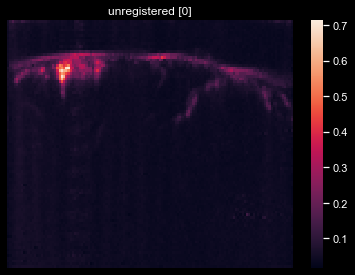

[:+:]-------------------------------------------------------------------------------[:+:]
[:+:] -- Shape: (128, 91)-- [:+:]


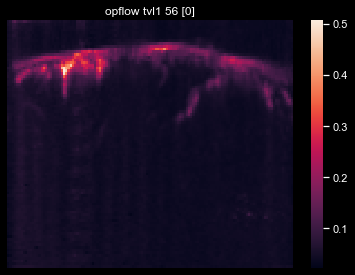

[:+:] -- Shape: (128, 91)-- [:+:]


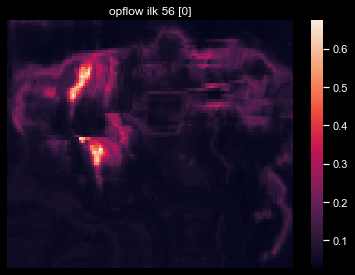

[:+:]-------------------------------------------------------------------------------[:+:]
[:+:] -- Shape: (128, 91)-- [:+:]


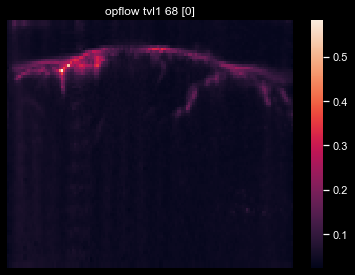

[:+:] -- Shape: (128, 91)-- [:+:]


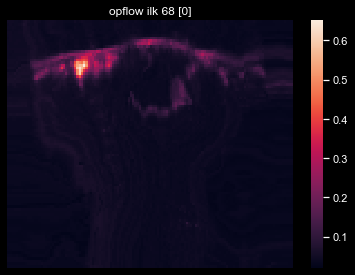

[:+:]-------------------------------------------------------------------------------[:+:]
[:+:] -- Shape: (128, 91)-- [:+:]


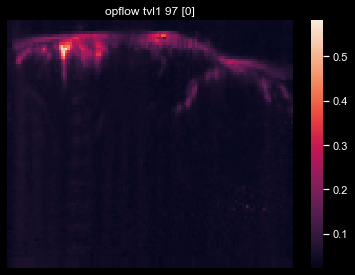

[:+:] -- Shape: (128, 91)-- [:+:]


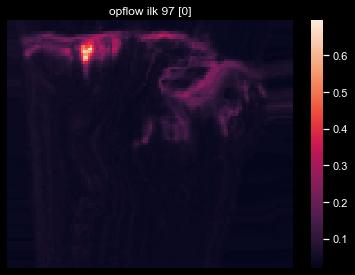

In [88]:
sizer= 0.5
frame= 0

print("[:+:] -----------------------------------------------------------------------------[:+:]")
displayHeatmap(unaligned180_300[ :, :, frame], sizer, title= "unregistered ["+ str(frame)+"]")
# displayHeatmap(refMean56, sizer=0.5, title= "refmean56")
# displayHeatmap(refMean68, sizer=0.5, title= "refmean68")
# displayHeatmap(refMean97, sizer=0.5, title= "refmean97")

print("[:+:]-------------------------------------------------------------------------------[:+:]")
displayHeatmap(opFlow_tvl1_avg56[ :, :, frame], sizer=0.5, title= "opflow tvl1 56 ["+ str(frame)+"]")
displayHeatmap(opFlow_ilk_avg56[ :, :, frame], sizer=0.5, title= "opflow ilk 56 ["+ str(frame)+"]")

print("[:+:]-------------------------------------------------------------------------------[:+:]")
displayHeatmap(opFlow_tvl1_avg68[ :, :, frame], sizer, title= "opflow tvl1 68 ["+ str(frame)+"]")
displayHeatmap(opFlow_ilk_avg68[ :, :, frame], sizer, title= "opflow ilk 68 ["+ str(frame)+"]")

print("[:+:]-------------------------------------------------------------------------------[:+:]")
displayHeatmap(opFlow_tvl1_avg97[ :, :, frame], sizer, title= "opflow tvl1 97 ["+ str(frame)+"]")
displayHeatmap(opFlow_ilk_avg97[ :, :, frame], sizer, title= "opflow ilk 97 ["+ str(frame)+"]")



### [::] -- Comparison

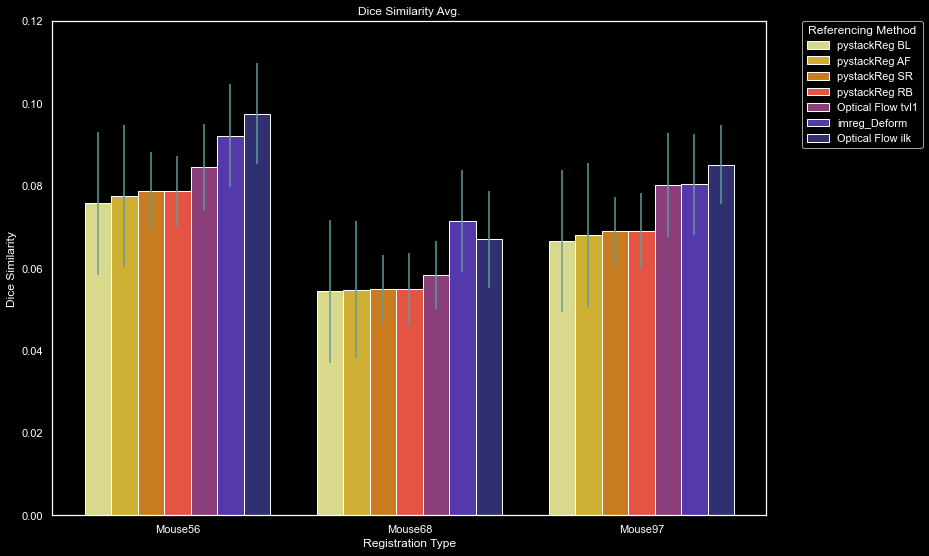

In [97]:
sizer= 1
unreg= unaligned_DM[0]
plt.figure(figsize = (12.8*sizer,9.1*sizer), facecolor= "black", edgecolor="black")
diceSims= np.asarray([
            psr_ref56_BL_DM, 
            psr_ref56_AF_DM,
            psr_ref56_SR_DM,
            psr_ref56_RB_DM,
            opFlow_tvl1_ref56_DM,
            deform56_DM,
            opFlow_ilk_ref56_DM,

            psr_ref68_BL_DM, 
            psr_ref68_AF_DM,
            psr_ref68_SR_DM,
            psr_ref68_RB_DM,
            opFlow_tvl1_ref68_DM,
            deform68_DM,
            opFlow_ilk_ref68_DM,

            psr_ref97_BL_DM, 
            psr_ref97_AF_DM,
            psr_ref97_SR_DM,
            psr_ref97_RB_DM,
            opFlow_tvl1_ref97_DM,
            deform97_DM,
            opFlow_ilk_ref97_DM,
        ])

#[+]-- Each ref method has its own array of dice similarities
    #-- By default, the errorbars will be the standard deviations of that bar grouping, not the stdDev of the array of similarities,
    #-- However, I have created made it such that the errorbars represent the std of the array of dice sims
diceMeans= np.empty(0)
diceErr= np.empty(0)
for i in diceSims:
    diceMeans= np.append(diceMeans, np.mean(i))
    diceErr= np.append(diceErr, np.std(i))
groupSize= 7
groupCnt= diceSims.shape[0]//groupSize
 
diceFrame = pd.DataFrame({
        'barCluster': np.concatenate((['Mouse56']*groupSize, ['Mouse68']*groupSize, ['Mouse97']*groupSize)),
        'clrCategory': ['pystackReg BL', 'pystackReg AF', 'pystackReg SR', 'pystackReg RB', 'Optical Flow tvl1', 'imreg_Deform', 'Optical Flow ilk']*groupCnt,
        'DiceSim': diceMeans,
        'Error' : diceErr
})


barPlot= sb.barplot(
           x='barCluster', 
           y=diceMeans, 
        #    yerr= diceErr,
           hue='clrCategory', 
           data= diceFrame, 
        #    palette= 'Spectral',
           palette='CMRmap_r',
#            errorbar= 'sd',
#            errcolor= 'cyan'
)


barPlot.set(xlabel='Registration Type',ylabel='Dice Similarity', title='Dice Similarity Avg.')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in barPlot.patches]
y_coords = [p.get_height() for p in barPlot.patches]
barPlot.errorbar(x=x_coords, y=y_coords, yerr=diceFrame["Error"], fmt="none", c="cadetblue")
plt.ylim(0, .12) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title= 'Referencing Method')
plt.show()

## __[:::]__ ToDo

##### __[:+:]__--- Pre-processing ---
 - [+] Fix tiff files, they seem to be only 91x3600 instead of 91x128x3600
 - [+] Convert one ref MAT into TIFF
 - [+] Convert all 82 MATs into TIFFs
 - [+] Split single tiff file (sample) into first 100-300 frames
 - [+] Split whole data set into first 100-300 frames
 - [+] Change reference and substack to 180-300 frames
 - [+] save unaligned tiff 
##### __[::]__-- Alignment Algos (120-300) ---
 - [+] Pystackreg Align with reference avg
 - [+] Pystackreg ALign with moving window size 60
 - [+] Pystackreg ALign with total Average
 - [+] PSR previous frame
 - [+] PSR first frame
 - [+] Moving windows of multiple sizes
 - [+] Affine type registration
 - [+] Scaled Rotation type registration
 - [+] Bilinear type registration
 - [-] Combined Algos
 - [+] ch^2 shift registration
 - [+] Data for imregDeform Registration
 - [ ] cross-correlation shift
 - [+] scikit-image registration
    - [+] optical_flow_ilk
    - [+] optical_flow_tvl1
    - [-] phase_cross_correlation

##### __[::]__-- Heuristics Functions ---
 - [x] Euclidian distance 
 - [x] Standard deviation
 - [x] Dice distance
 - [x] Min & Max
 - [-] Chi^2
 
 ##### __[::]__-- Data Viz ---
 - [+] Rigid Body Registration
 - [+] Animate pystackreg registered
 - [+] Affine type registration
 - [+] Scaled Rotation type registration
 - [+] Bilinear type registration
 - [-] DFT 
 - [ ] Reorganize: Add reference mouse, and omit other referencing methods
 - [ ] Error Bars

##### -[::]--- Misc ---
 - [+] Make Repo
 - [+] Form Functions
 - [+] Fix tensorInfo fx
 - [+] Bar Graphs
 - [ ] Better Animations
 - [+] Compare single images across different mice, and find the differences
 - [+] Create DataFrame for plotting
 - [+] References: #56, 68, 97
 - [ ] cPCA  analysis
 - [ ] Study Referencing Methods
 - [ ] Slides

In [ ]:
frame= 1
sizer= 0.5
# displayHeatmap(ilk68[ :, :, frame], sizer, title= "ilk68")
# displayHeatmap(ilk68_file[ :, :, frame], sizer, title= "ilk68_File")




print("\nilk diff----------------------------------")
print(sum(sum(sum(ilk56-ilk56_file))))
print(sum(sum(sum(ilk68-ilk68_file))))
print(sum(sum(sum(ilk97-ilk97_file))))

print("\ntvl diff----------------------------------")

print(sum(sum(sum(tvl56-tvl56_file))))
print(sum(sum(sum(tvl68-tvl68_file))))
print(sum(sum(sum(tvl97-tvl97_file))))

print(sum(sum(tvl56[ :, :, frame]-tvl56_file[ :, :, frame-1])))
print(sum(sum(tvl68[ :, :, frame]-tvl68_file[ :, :, frame-1])))
print(sum(sum(tvl97[ :, :, frame]-tvl97_file[ :, :, frame-1])))

# displayHeatmap(tvl68[ :, :, frame], sizer, title= "tvl68")
# displayHeatmap(tvl68_file[ :, :, frame], sizer, title= "tvl68_File")
displayHeatmap(tvl68[ :, :, 0], sizer, title= "tvl68_0")
displayHeatmap(tvl68_file[ :, :, 1], sizer, title= "tvl68_1")


print(tvl68_file.shape)
print(tvl68.shape)

